#  Pipeline : Images to Mesh

## 1. Load the dataset example :

### 1. Download dataset example

Download the image dataset [here](https://gforge.inria.fr/frs/download.php/file/35148/data_set_0962_A310_ARCH2013-05-13.zip) and extract it. After this, indicate the path in **data_path_directory** variable below.

In [3]:
data_path_directory = "./data_set_0962_A310_ARCH2013-05-13/"

### 1.2. Load  files paths :


In [4]:
import glob
import os

images_path = glob.glob(data_path_directory + '*.png')

files_path = dict()
for image_path in images_path:
    
    file_name = os.path.basename(image_path)
    date = file_name.split(' ')[0].split('_')[-1]
    if date not in files_path:
        files_path[date] = dict()
        
    if 'sv' in image_path:
        angle = file_name.split('_sv')[1].split('.png')[0]
        files_path[date][int(angle)] = image_path
    elif 'tv' in image_path:
        angle = -1
        files_path[date][int(angle)] = image_path
        
        
print "Number pot : 0962"
print "Genotype Id : A310"
print "Dates : ", files_path.keys()

Number pot : 0962
Genotype Id : A310
Dates :  ['2013-05-24', '2013-06-22', '2013-06-06', '2013-06-25']


### 1.3. Load Images

Here, we load all the image of the dataset to simply the toturial, commodly you load just the images you want process one after the other.

In [5]:
import cv2

images_dataset = dict()
for date in files_path:
    images_dataset[date] = dict()
    for angle in files_path[date]:
        images_dataset[date][angle] = cv2.imread(files_path[date][angle], flags=cv2.IMREAD_COLOR)

### 1.3. Display images 

You can view each image according to this date and angle of view like this :
Note : Angle top view is represented by negative number (-1)

<IPython.core.display.Javascript object>


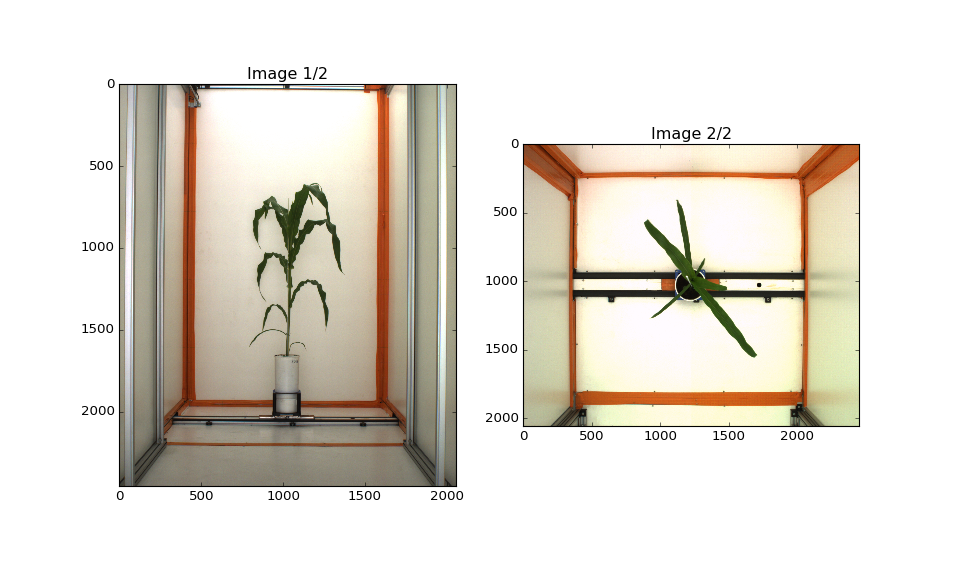

In [6]:
%matplotlib notebook

from alinea.phenomenal.viewer import show_images

show_images([images_dataset['2013-06-22'][0], images_dataset['2013-06-06'][-1]])

## 2. Binarization

### 2.1. Define a binarization routines

In [7]:
from alinea.phenomenal.plant_1 import(plant_1_mask_mean_shift, plant_1_mask_hsv, plant_1_mask_clean_noise)
from alinea.phenomenal.binarization_post_processing import (erode_dilate, dilate_erode)
from alinea.phenomenal.binarization_algorithm import (threshold_meanshift, threshold_hsv)
from alinea.phenomenal.binarization_post_processing import morphology_close

def routine_side_binarization(image, mean_image):

    threshold = 0.3
    dark_background = False

    hsv_min = (30, 11, 0)
    hsv_max = (129, 254, 141)
    mask_mean_shift = plant_1_mask_mean_shift()
    mask_hsv = plant_1_mask_hsv()
    mask_clean_noise = plant_1_mask_clean_noise()
    
    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Threshold the image with HSV min and max value
    binary_hsv_image = threshold_hsv(hsv_image, hsv_min, hsv_max, mask_hsv)

    # Threshold the image with difference between image and mean_image
    binary_mean_shift_image = threshold_meanshift(
        image, mean_image, threshold, dark_background, mask_mean_shift)

    # Add the two image
    result = cv2.add(binary_hsv_image, binary_mean_shift_image * 255)

    # Erode and dilate the image to remove possible noise
    result = erode_dilate(result, iterations=3, mask=mask_clean_noise)
    result = erode_dilate(result, iterations=1)

    result = morphology_close(result)
    
    return result


def routine_top_binarization(image):
    hsv_min = (42, 75, 28)
    hsv_max = (80, 250, 134)
    median_blur_size=9
    iterations=5
    
    # Convert image on HSV representation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Apply a median blur on the image
    hsv_image = cv2.medianBlur(hsv_image, ksize=median_blur_size)

    # Threshold the image with HSV min and max value
    bin_img = threshold_hsv(hsv_image, hsv_min, hsv_max)
    # dilate and erode the image to remove possible noise
    bin_img = dilate_erode(bin_img, kernel_shape=(3, 3),iterations=iterations)

    return bin_img

### 2.2. Binarize images

In [8]:
from alinea.phenomenal.binarization_algorithm import get_mean_image

# Select image at 2013/06/06
images = images_dataset['2013-06-06']

# Select the side image
side_images = [images[angle] for angle in range(0, 360, 30)]
# Compute the mean image of the side view image
mean_image = get_mean_image(side_images)

# Binarize all the images with the routine appropriate 
images_binarize = dict()
for angle in images:
    
    image = images[angle]
    
    if angle < 0:
        images_binarize[angle]= routine_top_binarization(image)
    else:
        images_binarize[angle] = routine_side_binarization(image, mean_image)

### 2.3. Display images binarize 

<IPython.core.display.Javascript object>


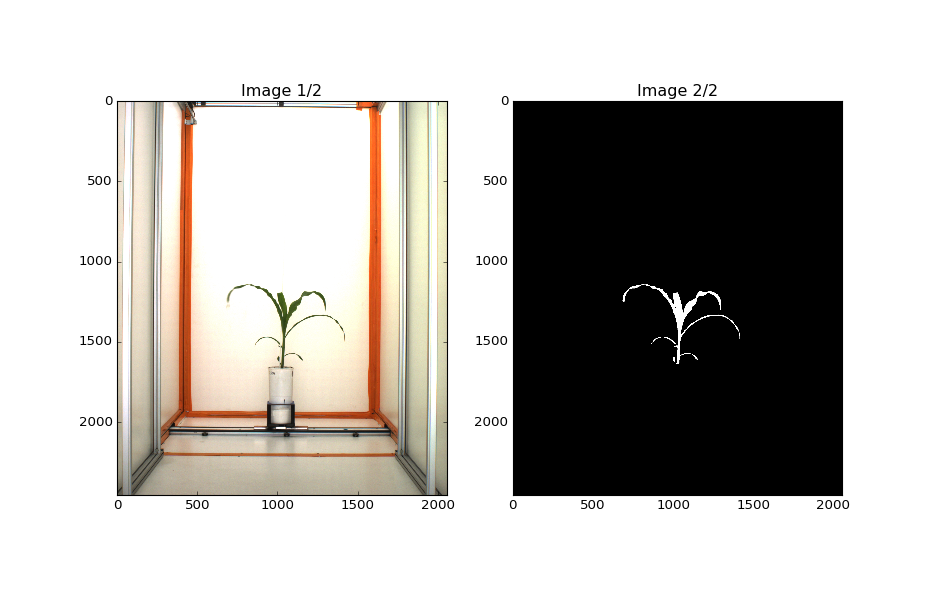

In [9]:
show_images([images_dataset['2013-06-06'][90], images_binarize[90]])

In [20]:
import gc

# Collect memory free
gc.collect()

617

### 2.4 Plant area estimation

In [12]:
import alinea.phenomenal.model

pixel_count = 0
for angle in range(0, 360, 30):
    pixel_count += cv2.countNonZero(images_binarize[angle])
    
pixel_count /= len(range(0, 360, 30))
area = alinea.phenomenal.model.plant_area(pixel_count)
print "Plant area estimation with mean number of pixel :", area

Plant area estimation with mean number of pixel : 0.138611875511


## 3. Multi-view reconstruction

### 3.1. Load calibration object

See Calibration notebook to calibrate camera if no camera parameters exist or load existing parameters like this :

In [13]:
from alinea.phenomenal.plant_1 import plant_1_calibration_camera_side_2_target

calibration = plant_1_calibration_camera_side_2_target()

### 3.2. Plant voxel

In [14]:
from alinea.phenomenal.plant_1 import plant_1_calibration_camera_side_2_target
from alinea.phenomenal.multi_view_reconstruction import reconstruction_3d

# Select images
images_projections = list()
for angle in range(0, 360, 30):
    img = images_binarize[angle].copy()
    projection = calibration.get_projection(angle)
    images_projections.append((img, projection))

# Multi-view reconstruction
voxel_size = 4
voxel_centers = reconstruction_3d(images_projections, voxel_size=voxel_size, verbose=True)

# Display it
alinea.phenomenal.viewer.show_points_3d(voxel_centers, scale_factor=2)

Iteration 1 / 10  :  8  -  8
Iteration 2 / 10  :  64  -  8
Iteration 3 / 10  :  64  -  8
Iteration 4 / 10  :  64  -  21
Iteration 5 / 10  :  168  -  58
Iteration 6 / 10  :  464  -  145
Iteration 7 / 10  :  1160  -  364
Iteration 8 / 10  :  2912  -  1107
Iteration 9 / 10  :  8856  -  4180
Iteration 10 / 10  :  33440  -  18436


### 3.3. Volume

In [16]:
from alinea.phenomenal.multi_view_reconstruction import volume

v = volume(voxel_centers, voxel_size)

print 'Volume of the plant voxel : ', v

Volume of the plant voxel :  1179904


## 4. Meshing

### 4.1 Marching cubes, Smoothing and Mesh decimation

In [17]:
import alinea.phenomenal.mesh

# Meshing
vertices, faces = alinea.phenomenal.mesh.meshing(voxel_centers, 
                                                 voxel_size,
                                                 reduction=0.95, 
                                                 smoothing_iteration=2, 
                                                 verbose=True)
# Display it
alinea.phenomenal.viewer.show_mesh(vertices, faces)

Marching cubes :
	Iso value : 0.5

	There are 23415 points.
	There are 46652 polygons.

Smoothing :
	Feature angle : 120.0
	Number of iteration : 2
	Pass band : 0.01

Decimation :
	Reduction (percentage) : 0.95

	Before decimation
	-----------------
	There are 23415 points.
	There are 46652 polygons.

	After decimation
	-----------------
	There are 1187 points.
	There are 2332 polygons.


### 4.2 Surface area estimation

In [18]:
import skimage.measure

surface = skimage.measure.mesh_surface_area(vertices, faces)

print surface

245001.771331


## 5. PlantGL Format

In [19]:
import openalea.plantgl.scenegraph as sg
import openalea.plantgl.all as pgl

scene = sg.Scene()
tset = sg.FaceSet(pointList=vertices, indexList=faces)
scene += tset

# Display it
pgl.Viewer.display(scene)